In [ ]:
from spyglass.spikesorting.analysis.v1.group import SortedSpikesGroup
from spyglass.decoding.v1.sorted_spikes import SortedSpikesDecodingV1
from spyglass.common import IntervalList


import numpy as np
import matplotlib.pyplot as plt

[2025-08-28 14:58:22,386][INFO]: DataJoint 0.14.6 connected to sambray@lmf-db.cin.ucsf.edu:3306


In [ ]:
# Logging for database export. Not necessary for replication

# from spyglass.common.common_usage import Export, ExportSelection

# paper_key = {"paper_id": "ms_stim_analysis"}

# analysis_id = "place_field_stabilit_2g"
# ExportSelection().start_export(**paper_key, analysis_id=analysis_id)

[15:02:05][INFO] Spyglass: Starting {'export_id': 50}


In [9]:
nwb_file_name = "Winnie20220717_.nwb"
pos_interval = "pos 3 valid times"

# nwb_file_name = "Yoshi20220513_.nwb"
# pos_interval = "pos 3 valid times"

place_field_list = []
epoch_fractions = []
for encoding in [
    "_opto_control_interval",
    "_opto_test_interval",
    "_stimulus_on_interval",
]:

    key = {
        "nwb_file_name": nwb_file_name,
    }
    decode_key = {**key, "encoding_interval": pos_interval + encoding}

    decoding_query = (
        SortedSpikesDecodingV1
        & decode_key
        & "sorted_spikes_group_name NOT LIKE 'manual_full_day'"
    )

    fit_model = decoding_query.fetch_model()

    # get place fields
    place_field = list(fit_model.encoding_model_.values())[0]["place_fields"]
    place_field_list.append(place_field)

    bin_centers = list(fit_model.encoding_model_.values())[0][
        "environment"
    ].place_bin_centers_

    encoding_interval = decoding_query.fetch1("encoding_interval")
    encoding_times = (
        IntervalList & key & {"interval_list_name": encoding_interval}
    ).fetch1("valid_times")
    encoding_length = np.sum(np.diff(encoding_times, axis=1))  # in seconds, not ms
    epoch_times = (IntervalList & key & {"interval_list_name": pos_interval}).fetch1(
        "valid_times"
    )
    epoch_length = np.sum(np.diff(epoch_times, axis=1))  # in seconds, not ms

    epoch_fractions.append(encoding_length / epoch_length)

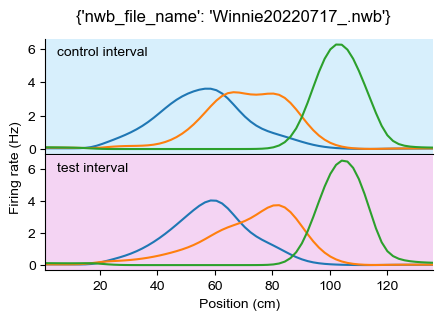

In [11]:
from ms_stim_analysis.Style.style_guide import interval_style

place_field_list[0].shape
loc = np.array([0.4, 0.5, 0.8])  # Winnie's
loc = np.array([0.4, 0.55, 0.75])  # Yoshi's
ind_max = np.argmax(place_field_list[0], axis=1)
loc = loc * ind_max.max()

loc = np.array([np.argmin(np.abs(ind_max - l)) for l in loc])

# loc = (len(place_field_list[0][0])*loc).astype(int)
# ind_sort = np.argsort(np.argmax(place_field_list[0],axis=1))
# loc = ind_sort[loc]

fig, ax = plt.subplots(nrows=2, sharex=1, sharey=0, figsize=(5, 3))
colors = [interval_style["control"], interval_style["test"], "grey"]
colors = [alpha_blending(c, 0.3) for c in colors]
labels = ["control interval", "test interval", "stimulus on times"]
for i, fields in enumerate(place_field_list[:-1]):
    data = fields[loc] * 500
    data = data / data.mean(axis=1)[:, None]  # normalize to mean firing rate
    # data = data/data.mean(axis=1)[:,None]
    ax[i].plot(
        bin_centers,
        data.T,
    )

    ax[i].set_facecolor(colors[i])
    # ax[i].set_alpha(.1)
    ax[i].text(5, data.max() * 0.9, labels[i])
    # ax[i].set_xlim(bin_centers.min(),bin_centers.max())

for a in ax:
    a.spines[
        [
            "right",
            "top",
        ]
    ].set_visible(False)
    # a.set_yticks([])

# for a in ax[:-1]:
# a.set_xticks([])

ax[-1].set_xlim(bin_centers.min(), bin_centers.max())
ax[-1].set_xlabel("Position (cm)")
# ax[-1].set_ylabel("$f_{position}$ / $f_{average}$",va="bottom",ha="left")
ax[-1].set_ylabel("Firing rate (Hz)", va="bottom", ha="left")

plt.subplots_adjust(wspace=0, hspace=0.01)
plt.suptitle(key)

plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["font.family"] = "Arial"
fig.savefig(
    "../Figures/Fig_2/Fig_2e_place_field_stability_winnie_fixed_scale.svg",
    format="svg",
)